### <font color = "# 006666">*__Machine Learning project__*<br />


In [173]:
#importing pandas, matplotlib and numpy libraries.
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_roc_curve,plot_confusion_matrix
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from numpy import interp
from tqdm.notebook import tqdm
from scipy import stats
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

In [174]:
#load the data
X = pd.read_csv('feature_data.csv')
print(X.shape)
y = pd.read_csv('label_data.csv')
y = y['cancelation']
X_test = pd.read_csv('feature_data_test.csv')

(89542, 34)


#### <font color = "# 006666">*__We decided to split the data at this stage.__*<br />

In [175]:
#split into train and test(validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,stratify=y ,random_state=42)
X_safe = X_train.copy(deep = True)
y_safe = y_train

## <font color = "# 006666">*__Part 1: Data Exploration__*<br />

#### <font color = "# 006666">*__Getting a glimpse of the data__*<br />

In [176]:
pd.set_option('display.max_columns', None)
X_train.head()

,Unnamed: 0,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,order_type,acquisition_channel,prev_canceled,prev_not_canceled,changes,deposit_type,agent,company,customer_type,adr,anon_feat_0,anon_feat_1,anon_feat_2,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
692,28530,NaN,2016,September,week_39,24,2,0.0,0,GBR,Offline TA/TO,TA/TO,0,0,0.0,No Deposit,40.0,NaN,Contract,4875.0,4.0,8,0,0,3,3.0,0.0,0.0,1,1.0,0.357670,17.201401,True,NaN
56249,83268,15.0,2016,January,week_5,26,1,0.0,0,FRA,Corporate,Corporate,0,0,0.0,No Deposit,91.0,NaN,Transient,80.0,0.0,1,0,0,0,0.0,0.0,0.0,0,0.0,0.564160,4.026381,True,NaN
42320,63812,29.0,2017,NaN,week_8,22,2,0.0,0,LIE,Online TA,TA/TO,0,0,0.0,No Deposit,9.0,NaN,Transient,986.0,0.0,4,0,0,3,3.0,0.0,0.0,1,0.0,0.475475,5.398289,True,NaN
9210,119183,209.0,2017,August,week_35,28,2,0.0,0,GBR,Online TA,TA/TO,0,0,1.0,No Deposit,9.0,NaN,Transient,99.0,1.0,3,3,0,0,3.0,0.0,0.0,0,0.0,0.268950,14.502681,True,NaN
67815,89364,0.0,2017,February,week_6,5,1,0.0,0,PRT,Offline TA/TO,TA/TO,2,11,0.0,No Deposit,94.0,NaN,Transient,45.0,1.0,0,0,1,0,0.0,0.0,0.0,2,0.0,0.634291,NaN,False,NaN


#### <font color = "# 006666">*__We took a look at the features' statistics, such as mean, std, count.__* <br /> 
#### <font color = "# 006666">*__Categorical features:__*<br />  

In [177]:
display(X_train.describe(include = [object]))

,order_month,order_week,country,order_type,acquisition_channel,deposit_type,customer_type
count,60246,62679,59636,62679,62679,56377,55744
unique,12,53,153,8,5,3,4
top,August,week_33,PRT,Online TA,TA/TO,No Deposit,Transient
freq,7031,1890,24321,29692,51427,49324,41958


#### <font color = "# 006666">*__Interesting points:__*<br />  
* *The data is collected from 163 county, we shall explore the feature later in the notebook.*
* *The features acquision_channel and deposit_type has a noticeable high frequency of its top value.*

#### <font color = "# 006666">*__Numeric features:__*  <br />  

In [178]:
display(X_train.describe(exclude = [object]))

,Unnamed: 0,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,agent,company,adr,anon_feat_0,anon_feat_1,anon_feat_2,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
count,62679.000000,53744.000000,62679.000000,62679.000000,62679.000000,62676.000000,62679.000000,62679.000000,62679.000000,60233.000000,54200.000000,3492.000000,60625.000000,60307.000000,62679.000000,62679.000000,62679.000000,62679.000000,59866.000000,59748.000000,59770.000000,62679.000000,60057.000000,60769.000000,59223.000000,62679,4011.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31465,NaN
mean,59904.252908,103.678420,2016.159288,15.828986,1.856316,0.103740,0.007834,0.086552,0.134734,0.223897,86.174151,189.158935,2209.721122,0.924072,2.495684,0.560539,0.032228,0.991193,1.330471,2.375460,0.062941,0.571978,0.334416,0.426443,8.854694,NaN,0.370481
std,34521.690348,106.776942,0.708332,8.780041,0.547877,0.399071,0.089240,0.832021,1.443729,0.662053,110.483503,130.606203,4403.932542,0.994391,1.901708,1.072056,0.176606,1.696485,1.880174,17.471608,0.244096,0.795130,0.471790,0.128257,5.233335,NaN,0.482994
min,4.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162005,0.038632,NaN,0.000000
25%,30011.000000,18.000000,2016.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,67.000000,84.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.327103,4.471688,NaN,0.000000
50%,60016.000000,69.000000,2016.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,149.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.424607,8.426605,NaN,0.000000
75%,89866.000000,159.000000,2017.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,1235.000000,2.000000,3.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.510496,12.704154,NaN,1.000000


#### <font color = "# 006666">*__Interesting points:__*  <br />  
* *Noticeable low count in anon_feat_13, we may have to drop this feautre.*
* *Noticeable high std in the feature adr compared to the rest.*

#### <font color = "# 006666">*__To understand better the dataset and features we looked at the distribution of each feature:__* <br />

#### <font color = "# 006666">*__Numeric Features:__* <br />

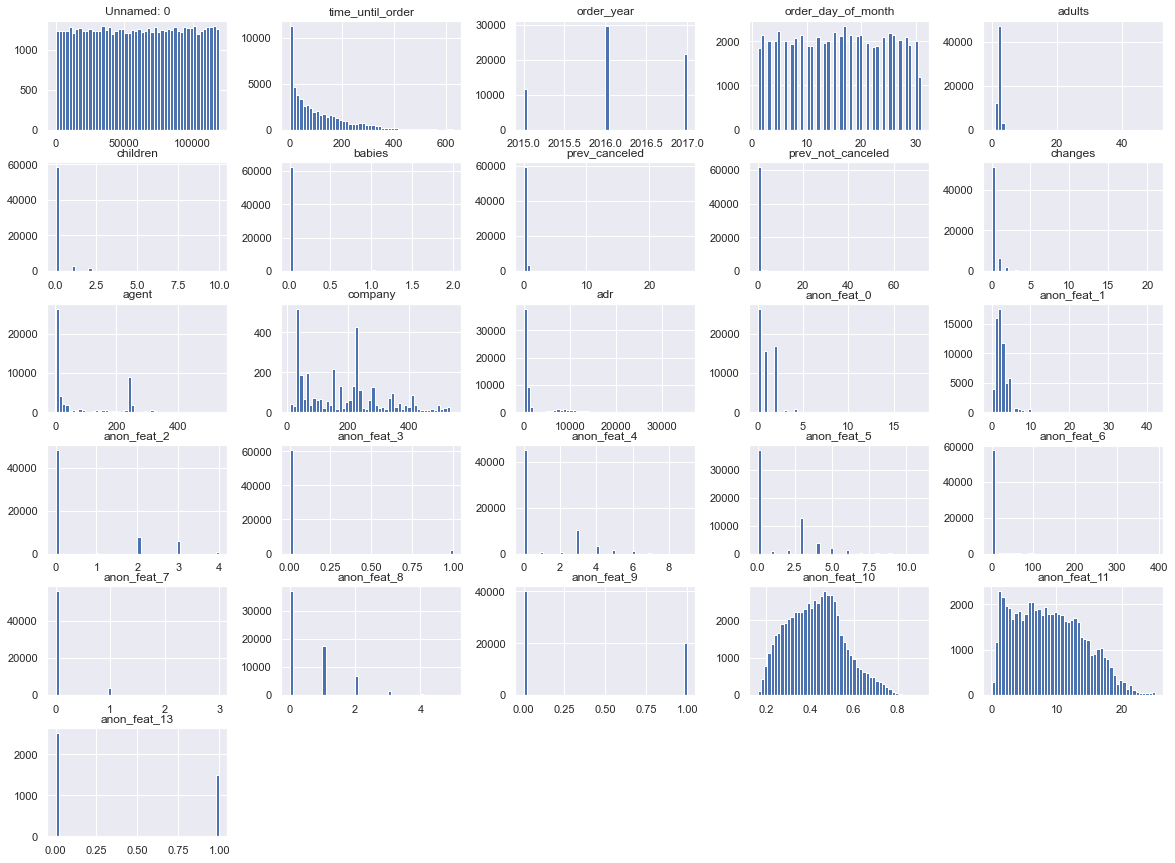

In [179]:
numeric_features = X_train.select_dtypes(include=np.number)
numeric_features.hist(bins=50,figsize=(20,15))
plt.show()

##### <font color = "# 006666">*__We can see that we have quite a few sparse features which we may want to remove because they won't add much to our data if they don't contribute meaningful information.__* <br />


<AxesSubplot:>

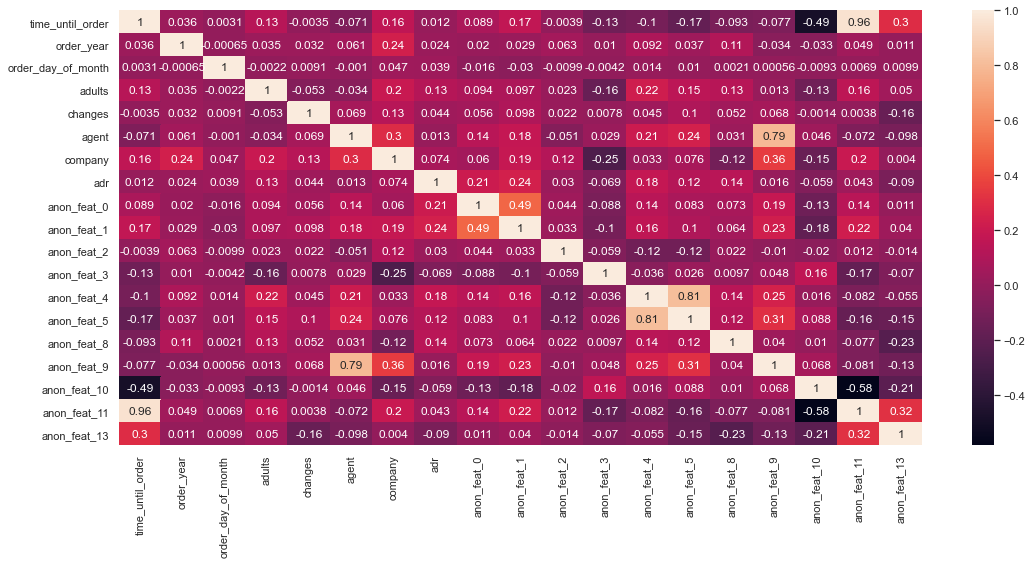

In [180]:
corr_mat=numeric_features.drop(['prev_not_canceled','prev_canceled','babies','children','anon_feat_6',\
                    'anon_feat_7','Unnamed: 0'],axis=1,inplace=False) ## removing sparse features for cleaner plot 
corr_mat = corr_mat.corr()
plt.figure(figsize=(18,8))
sns.heatmap(corr_mat,annot=True)


##### <font color = "# 006666">*__We noticed that time_until_order is highly correlated with anon_feature_11,__* <br />
##### <font color = "# 006666">*__and that anon_feat_5 correlates highly with anon_feat_4,__* <br />
##### <font color = "# 006666">*__as does agent with anon_feat_9.__* <br />

##### <font color = "# 006666">*__We checked correlations between features and our label data:__* <br />

In [181]:
X_train.corrwith(y).sort_values(ascending=False)

anon_feat_13          1.000000
anon_feat_11          0.313683
time_until_order      0.294366
prev_canceled         0.110757
anon_feat_6           0.059325
adults                0.057988
anon_feat_1           0.025495
order_year            0.011501
children              0.004363
company               0.001678
anon_feat_12         -0.003437
anon_feat_0          -0.003838
order_day_of_month   -0.009120
anon_feat_2          -0.017354
babies               -0.031103
prev_not_canceled    -0.059963
anon_feat_4          -0.062781
adr                  -0.072934
anon_feat_3          -0.081338
agent                -0.082948
anon_feat_9          -0.134448
changes              -0.143996
anon_feat_5          -0.177612
anon_feat_7          -0.197923
anon_feat_10         -0.203986
anon_feat_8          -0.235674
Unnamed: 0           -0.246825
dtype: float64

In [182]:
X_train['anon_feat_13'].isna().sum()

58668

##### <font color = "# 006666">*__As we can see , although anon_feat_13 is perfectly correlated with our label data, it contains over 90% missing values , so it may not be that informative for us__* <br />

In [183]:
y = np.array(y) 

#### <font color = "# 006666">*__Categorical Features:__* <br />

order_month :
August       7031
July         6382
May          5991
October      5649
April        5562
June         5517
September    5296
March        4999
February     4022
November     3440
December     3389
January      2968
Name: order_month, dtype: int64
order_month  contains  13  labels


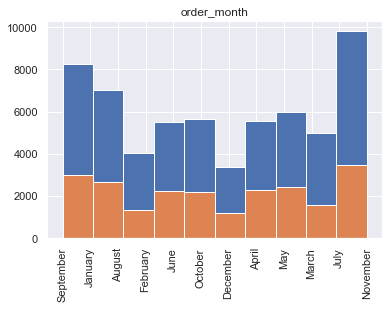

order_type :
Online TA        29692
Offline TA/TO    12741
Groups           10368
Direct            6623
Corporate         2740
Complementary      386
Aviation           127
Undefined            2
Name: order_type, dtype: int64
order_type  contains  8  labels


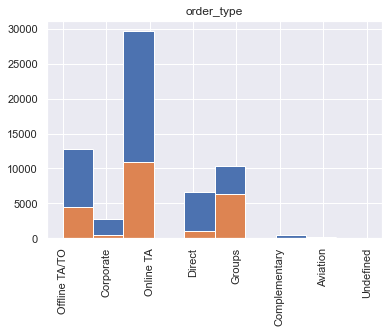

acquisition_channel :
TA/TO        51427
Direct        7693
Corporate     3462
GDS             94
Undefined        3
Name: acquisition_channel, dtype: int64
acquisition_channel  contains  5  labels


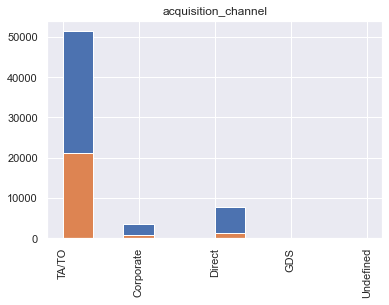

deposit_type :
No Deposit    49324
Non Refund     6968
Refundable       85
Name: deposit_type, dtype: int64
deposit_type  contains  4  labels


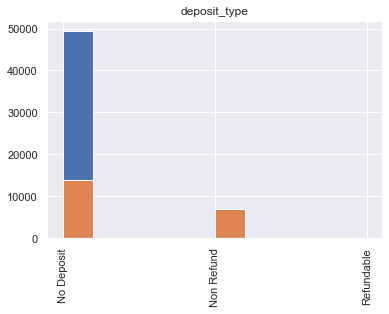

customer_type :
Transient          41958
Transient-Party    11668
Contract            1860
Group                258
Name: customer_type, dtype: int64
customer_type  contains  5  labels


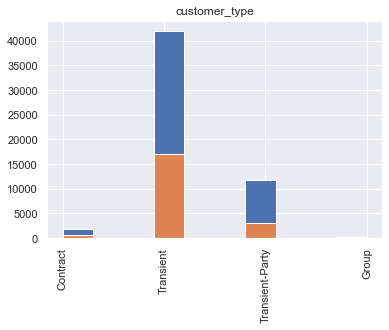

In [184]:
cat_features = X_train.select_dtypes(exclude=np.number)

### categorical preprocessing
for category in cat_features:
    if category not in ['country','order_week', 'anon_feat_12']: #we see country later in the notebook
        print (category + " :")
        print(X_train[category].value_counts())
        print(category, ' contains ', len(X_train[category].unique()), ' labels')
        X_train[category].hist()
        X_train[category].unique()
        X_train[category][y_train==1].hist()
        plt.xticks(rotation = 90)
        plt.title(category)
        plt.show()
        

##### <font color = "# 006666">*__The deposit type might not be useful__* <br />

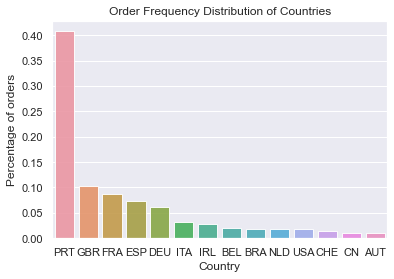

In [185]:
# X_train[['country']] = X_train[['country']].fillna(value = 'OTHER')

country_count = X_train['country'].value_counts(normalize = True)
country_count = country_count[country_count > 0.01] # countries with frequencies under this threshold do not represent the data 
sns.set(style = "darkgrid")
sns.barplot(country_count.index, country_count.values, alpha = 0.9)
plt.title('Order Frequency Distribution of Countries')
plt.ylabel('Percentage of orders', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.show()

## <font color = "# 006666">*__Part 2: Pre-processing__*<br />

#### <font color = "# 006666">*__We made the decision to drop columns according to:__*<br />
1. The count of the missing values 
2. The low variance, and sparsed features.
3. Hight correlation with other features.

In [186]:
#counting missing values
df = X_train
total = df.shape[0]
percent = pd.DataFrame((df.isnull().sum()/total*100).sort_values(ascending=False),columns = ['null percent']) 
percent.head(3)


,null percent
company,94.428756
anon_feat_13,93.600728
time_until_order,14.255173


##### <font color = "# 006666">*__Which means that we need to drop company and anon_feat_13__*<br />

In [187]:
#counting zeros with low variance
df = X_train
total = df.shape[0]
percent = pd.DataFrame(((df == 0).sum(axis=0)/total*100).sort_values(ascending=False),columns = ['zeros percent'])
percent.head(8)

,zeros percent
babies,99.226216
prev_not_canceled,96.973468
anon_feat_3,96.777230
prev_canceled,94.534054
children,92.807798
anon_feat_6,92.265352
anon_feat_7,89.382409
changes,81.500981


##### <font color = "# 006666">*__Which means we need to drop babies, prev_not_canceled, anon_feat_3, prev_canceled, children, anon_feat_6, anon_feat_7 and changes.__*<br />

In [188]:
# Custom Transformer to drop columns
# first we create the function to be applied to our data
def DropCols(df):
    df.drop(['Unnamed: 0','prev_not_canceled','prev_canceled','babies','children','anon_feat_9',
             'anon_feat_6','anon_feat_7','company', 'anon_feat_3','anon_feat_13','changes'],axis=1,inplace=True)  
    return df 
# then we convert the function into a custom transformer
DropCols = FunctionTransformer(DropCols) 

### <font color = "# 006666">*__The outliers:__* <br />
##### <font color = "# 006666">*__Since the goal of dealing with the outliers is to stabilize the training process, we'll apply our work only on the X_train test, and later we will apply it to the total X, and it will not be part of the pipeline.__* <br />

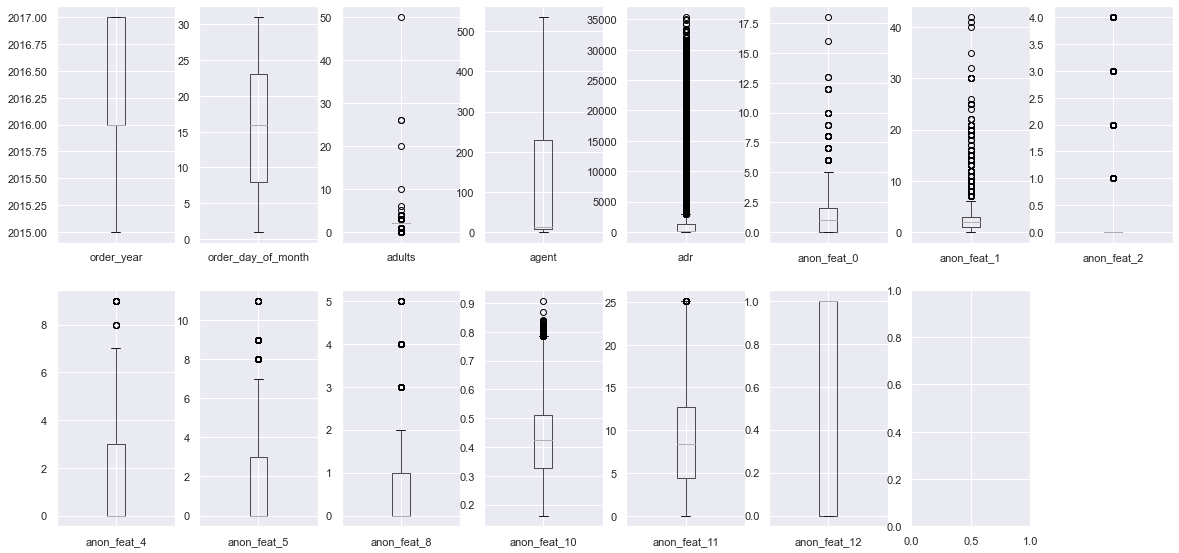

In [189]:
#check box plot 
df = X_train.copy(deep = True)
df.drop(['Unnamed: 0','prev_not_canceled','prev_canceled','babies','children','anon_feat_9',
             'anon_feat_6','anon_feat_7','company', 'anon_feat_3','anon_feat_13','changes'],axis=1,inplace=True)  
droplist = ['Unnamed: 0','prev_not_canceled','prev_canceled','babies','children',
             'anon_feat_6','anon_feat_7','company', 'anon_feat_3','anon_feat_13','changes']
cont = [var for var in df.columns if df[var].dtype!='O']
X_train['anon_feat_12'] = X_train['anon_feat_12'].astype(int)
list_ = [item for item in cont if item not in droplist]

#plotting boxplots 
i = 1
for f in list_:
    df.boxplot(column =f, figsize = (20,20),vert = True)
    plt.subplot(4,8,i)
    i+=1

##### <font color = "# 006666">*__A reminder: we already know that only anon_10 and anon_11 have approximately gaussian distribution.__* <br />


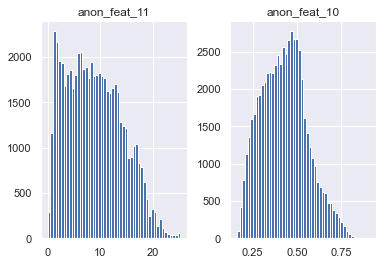

anon_feat_11:
 p(zscore > 3): 0.12603902423459212

anon_feat_10:
 p(zscore > 3): 0.055840074027983855



In [190]:
df[['anon_feat_11','anon_feat_10']].hist(bins=50)
plt.show()

for cat in ['anon_feat_11','anon_feat_10']: #check how much data we'll lose if we 
        zscore = ((df[cat] - df[cat].mean()) / (df[cat].std(ddof=0)))
        print(cat + ":\n p(zscore > 3): " + str((zscore > 3).mean()*100) +"\n")

##### <font color = "# 006666">*__We noticed that the outliers are only a small percent of the data, so we decided to use zscore to clean the outliers:__*<br />


<AxesSubplot:>

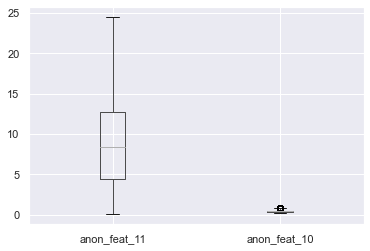

In [191]:
zscore = ((df[['anon_feat_11','anon_feat_10']] - df[['anon_feat_11','anon_feat_10']].mean()) / (df[['anon_feat_11','anon_feat_10']].std(ddof=0)))
df = df[zscore < 3]
df.boxplot(column =['anon_feat_11','anon_feat_10'], vert = True)

##### <font color = "# 006666">*__As for the rest of the features, we can see that their distribution could be chi squared with some k, or any other distribution with a long tail, so we decided not to drop more data.__*<br />


In [192]:
#function for outliers
def outlier_cleanup(df1,y):

    df = df1.copy()
    for cat in list_:
        zscore = ((df[cat] - df[cat].mean()) / (df[cat].std(ddof=0)))
        if cat in ['anon_feat_11','anon_feat_10']:
            df = df[zscore < 3]
            y  = y[zscore < 3]
    return (df, y)


In [193]:
# X_train , y_train = outlier_cleanup(X_train, y_train)

### <font color = "# 006666">*__Feature Engineering:__*<br />

#### <font color = "# 006666">*__Mathematical Transformation of Date features__*<br />


##### <font color = "# 006666">*__We know that month/day of month are cyclical by nature, for ex: month 1 comes after month 12, however the classifiers we use assume that these features are linear (as in month 1 is really far from month 12). We would like our classifiers to be able to better utilize this data, therefore we will transform these features so they will have cyclical order.In order to accomplish this we can utilize the cyclical nature of the sine and cosine functions (if we only used sine then there would be two values for any given line across the graph ,therefore we need use both sine/cosine to negate that effect). for this we wil generate 2 new columns to replace each time period.__*<br />


$x=\sin \frac{2\pi \cdot time\hspace{1mm}period\hspace{1mm}_i}{total\hspace{1mm}time\hspace{1mm}periods}$ 

$y=\cos \frac{2\pi \cdot time\hspace{1mm}period\hspace{1mm}_i}{total\hspace{1mm}time\hspace{1mm}periods}$

In [194]:
# convert month name to month number e.g. Jan=1,feb=2..
X_train['order_month'] = pd.to_datetime(X_train.order_month, format='%B').dt.month 
X_val['order_month'] = pd.to_datetime(X_val.order_month, format='%B').dt.month 
X_test['order_month'] = pd.to_datetime(X_test.order_month, format='%B').dt.month 

In [195]:
# Create Function to implement the date variable manipulations
def cyclic_date(df):
    # mathematical transformation to account for cyclic nature of months in a year
    df['sin_month'] = np.sin(2*np.pi*df.order_month/12)
    df['cos_month'] = np.cos(2*np.pi*df.order_month/12)
    # same thing for day of month
    df['sin_day_of_month'] = np.sin(2*np.pi*df.order_day_of_month/30)
    df['cos_day_of_month'] = np.cos(2*np.pi*df.order_day_of_month/30)
    
    df.drop(['order_month','order_day_of_month'],axis=1,inplace=True)
    return df
DateTransformer = FunctionTransformer(cyclic_date) # convert to transformer for future pipeline use


##### <font color = "# 006666">*__We can visualize this cyclical transformation.__*<br />

##### <font color = "# 006666">*__Numeric preprocessing:__* <br /> 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


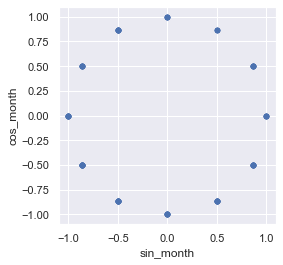

In [196]:
X_copy = X_train.copy(deep=True)
X_copy = cyclic_date(X_copy)
X_copy.sample(150).plot.scatter('sin_month','cos_month').set_aspect('equal');

### <font color = "# 006666">*__Pipelines:__* <br />
##### <font color = "# 006666">*__We have chosen to utilize Sklearns Pipeline object to chain together our preprocessing/feature engineering so that we may avoid repeat coding, and also to ensure we dont miss any steps when applying our preprocessing to our final test data__* <br />

In [197]:
# define individual transformers in a pipeline
numeric_preprocessing = Pipeline(steps=[         
    ('convert_date',DateTransformer), # sin/cosin trasformation of date features
    ('drop_cols',DropCols), # dropping uneccesary columns
    ('variance_thresh',VarianceThreshold(threshold=0.25)), # remove low variance features
    ('imputer', SimpleImputer(strategy='mean')), # impute missing values with the mean of the column
    ('scaler', StandardScaler()), # scaling our data 
    ('pca',PCA())]) # applying pca for dimensionality reducution 



### <font color = "# 006666">*__Using PCA for dimensionality reduction__* <br />
##### <font color = "# 006666">*__To avoid the curse of dimensionality , we shall plot the pca explained variance ratio so that we can select a subset of features that will accurately represent our data.__* <br />


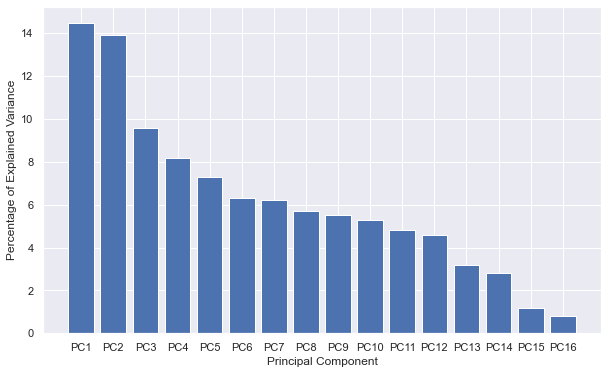

In [198]:
#----plotting pca explained variance
X_copy = X_train.copy(deep=True)
numeric_features = X_copy.select_dtypes(include=np.number)
numeric_preprocessing.fit_transform(numeric_features)

per_var = np.round(numeric_preprocessing['pca'].explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize = (10,6)) 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()

#----trying to print names of most important components

# index =[f'PC {str(i)}' for i in range(13)]
# print(pd.DataFrame(pca.components_,columns=num_feature_names, index =index))

##### <font color = "# 006666">*__Or, another way to look at it is the cumulative explained variance we recieve from a given amount of components.__* <br />


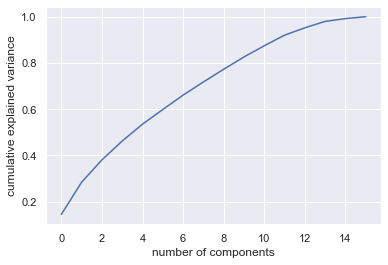

In [199]:
plt.plot(np.cumsum(numeric_preprocessing['pca'].explained_variance_ratio_)) #plot cumulative explained variance 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

#### <font color = "# 006666">*As we can see from the plot above , we can explain about 95% of the variance in our numeric data with the first 12 principal components , so we'll select 12 principal components in our final pipeline to reduce dimension while retaining around 95% of the variance.* <br />


In [200]:
numeric_preprocessing.set_params(pca__n_components=12) # set parameters of pca in our pipeline

Pipeline(steps=[('convert_date',
                 FunctionTransformer(func=<function cyclic_date at 0x00000282631C3550>)),
                ('drop_cols',
                 FunctionTransformer(func=<function DropCols at 0x0000028267060D30>)),
                ('variance_thresh', VarianceThreshold(threshold=0.25)),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=10))])

### <font color = "# 006666">*__Categorical Features preprocessing__* <br />
##### <font color = "# 006666">*__For our categorical features, we again will utilize Pipeline to chain together our preprocessing steps which include imputing missing values and encoding with dummy variables.__* <br />

In [201]:
cat_features = X_copy.select_dtypes(exclude=np.number)
cat_vars = cat_features.columns
### categorical preprocessing
#missing values
total = X_train[cat_vars].isnull().sum().sort_values(ascending=False)
percent = (X_train[cat_vars].isnull().sum()/X_train[cat_vars].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
missing_data


,Total,Percent
customer_type,6935,11.064312
deposit_type,6302,10.054404
country,3043,4.854896
order_week,0,0.000000
order_type,0,0.000000
acquisition_channel,0,0.000000


In [202]:
#filling the nan values with random values
#['order_week', 'country', 'order_type', 'acquisition_channel', 'deposit_type', 'customer_type'
def fill_na_random(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: np.random.choice(df[column].dropna().values) 
                                      if pd.isnull(x) else x)
    return df
FillRand = FunctionTransformer(fill_na_random) # convert function to transformer for pipeline use

# def fill_na_mode(df):
#     df = df.fillna(df.mode().iloc[0])
#     return df
# FillMode = FunctionTransformer(fill_na_mode)

In [203]:
# define the categorical preprocessing steps in a pipeline
categorical_preprocessing = Pipeline(steps = [('fill_rand',FillRand),
                                             ('ohe',OneHotEncoder(categories='auto',handle_unknown='ignore'))])

In [204]:
# defining which transformer applies to which columns

num_feature_names = X_train.select_dtypes(include=np.number).columns
cat_feature_names = cat_vars
preprocess = ColumnTransformer([
    ('numeric_preprocessing', numeric_preprocessing,
     num_feature_names),
    ('categorical_preprocessing', categorical_preprocessing, 
     cat_feature_names)
])


#### <font color = "# 006666">*__Applying the preprocess to the validation and test sets, preparing for Part 4(evaluating the model):__* <br />

In [205]:
ids = X_test['Unnamed: 0'] # get ids for later use in submission process

X_train = preprocess.fit_transform(X_train) # fit preprocessing to our train data:

X_val = preprocess.transform(X_val) # transform our validation / test data

X_test = preprocess.transform(X_test)

## <font color = "# 006666">*__Part 3+4: Model selection and Testing__* <br />

#### <font color = "# 006666">*__Fitting the models to our training data__* <br />

In [206]:
### our 2 simple classifiers

reg = LogisticRegression(penalty ='l2',tol=0.0001, C=1,solver='saga') 
knn = KNeighborsClassifier(n_neighbors = 20, weights = "uniform", metric = "euclidean",algorithm = "brute")

### our 2 advanced classifiers
rf = RandomForestClassifier(n_estimators = 100,max_depth = 10,n_jobs = -1)  
mlp = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001,tol=0.0001)

clfs = [reg, knn, rf, mlp]

#fit each classifier to our training data:
for clf in clfs:
    clf.fit(X_train,y_train)


##### <font color = "# 006666">*__Confusion Matrix__* <br />


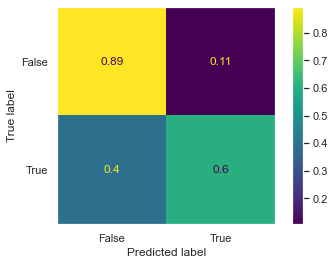

In [207]:
plot_confusion_matrix(reg,X_train,y_train,normalize='true')
plt.grid(False)
plt.show()

#### <font color = "# 006666">*From the plot above we can see that the classifier correctly identified 89% of True negatives(top left), as well as  61% of True Positives(bottom right),* <br />
#### <font color = "# 006666">*The top right cell represents the missclassified negatives(False Positives)and the bottom left cell represents the misclassified positives (False Negatives).* <br />


#### <font color = "# 006666">*__Now we will test out 4 different classifiers to see which one has the greatest prediction accuracy,__* <br />
#### <font color = "# 006666">*__We'll start by creating helper functions for plotting:__* <br />

In [208]:
def KfoldPlot(X, y, clf, k,ax=None):
    
    #str(clf) returns the name of the classifier, we set this as the title.
    clfname = str(clf)[:str(clf).find("(")]
    
    #We prepare a figure, which will be filled in with some graphs inside.
    plt.figure()
    
    if(ax is None):
        ax=plt.gca()
    
    kf = KFold(n_splits=k, shuffle=False)

    mean_tpr = np.zeros(100)
    mean_fpr = np.linspace(0, 1, 100)

    i=1

    for train_index, validation_index in kf.split(X):
        
        #Splitting into train and validation, based on the current fold.
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #fit with X_train and y_train.
        clf.fit(X_train, y_train)
        
        prob_prediction = clf.predict_proba(X_validation)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_validation, prob_prediction)
        
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        ax.plot(fpr, tpr, color='#D3D3D3')
        i+=1
    
    ax.plot([0], [0], color='#D3D3D3', linestyle='-', label='K-folds')    
    

    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    #plot the random-guess line
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    # plot the mean roc
    ax.plot(mean_fpr, mean_tpr, color='red', linestyle='-', label='Mean ROC (area = %0.3f)' % mean_auc)

    #Setting some boundaries and adding a legend
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC for ' + clfname)
    ax.legend(loc="lower right")
#     plt.show()
    return ax

In [209]:
def eval_models(X,y,clfs,folds):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    axes=[ax1,ax2,ax3,ax4]
    for ax, clf in zip(axes, clfs):
        KfoldPlot(X,y,clf,folds,ax=ax)
    plt.show()
    

In [210]:
def validate_models(X_val,y_val,clfs):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    axes=[ax1,ax2,ax3,ax4]
    for ax, clf in zip(axes, clfs):
        plot_roc_curve(clf,X_val,y_val,ax=ax)
    plt.show()
    

#### <font color = "# 006666">*__Plot K Fold CV with ROC for each of the 4 models__* <br />

#### <font color = "# 006666">*__First we'll plot using the training data:__* <br />

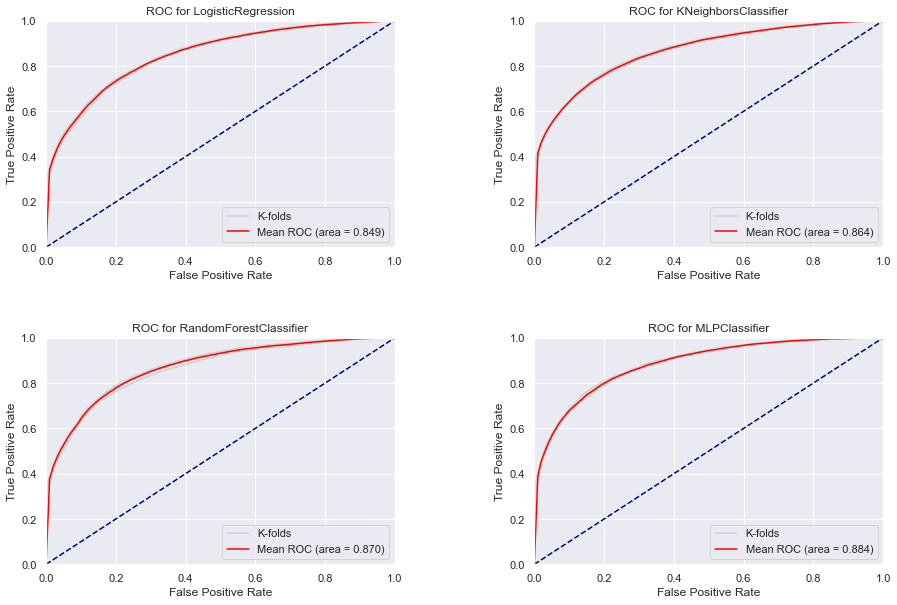

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [211]:
eval_models(X_train,y_train,clfs,5)

#### <font color = "# 006666">*__Next , we'll plot using the validation data to check if our models are overfitting__* <br />

In [ ]:
### our 2 simple classifiers

reg = LogisticRegression(penalty ='l2',tol=0.0001, C=1,solver='saga') 
knn = KNeighborsClassifier(n_neighbors = 20, weights = "uniform", metric = "euclidean",algorithm = "brute")

### our 2 advanced classifiers
rf = RandomForestClassifier(n_estimators = 100,max_depth = 10,n_jobs = -1)  
mlp = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001,tol=0.0001)

clfs = [reg, knn, rf, mlp]

#fit each classifier to our training data:
for clf in clfs:
    clf.fit(X_train,y_train)

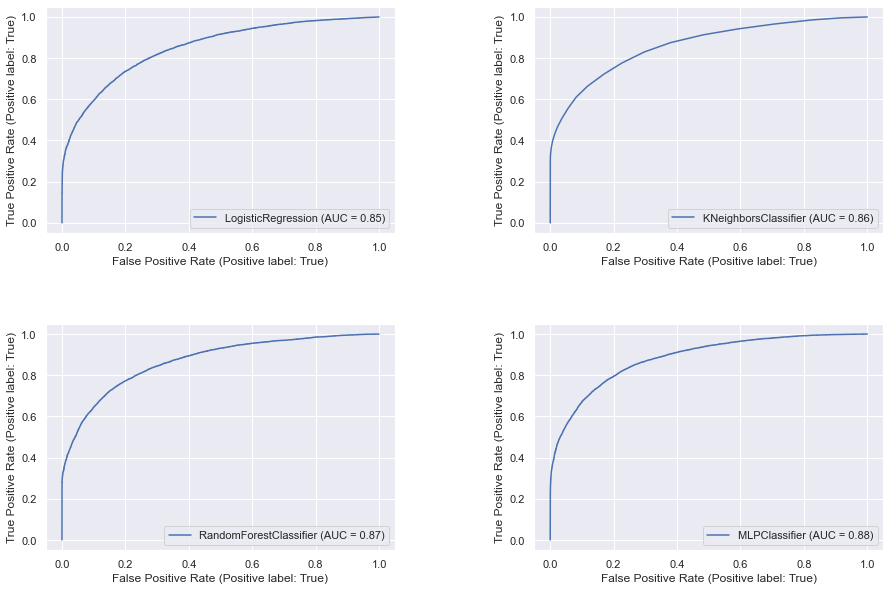

In [212]:
validate_models(X_val,y_val,clfs)

#### <font color = "# 006666">*As we can see from the above plots, We are not overfitting our data because when we applied each classifier to the validation data, we recieved very similar AUC scores as we did with the training data, therefore , we can conclude that our models will perform similarly on other unseen data. Based on this plot we can see that indeed the MLPClassifier was the highest scoring model and therefore we shall select it for our final predictions.* <br />

# <font color = "# 006666">*__Submission__* <br />

In [41]:
tot_X = X.copy(deep = True)
tot_X , y = outlier_cleanup(tot_X,y)
tot_X['order_month'] = pd.to_datetime(tot_X.order_month, format='%B').dt.month 
tot_X = preprocess.transform(tot_X) # transform our validation / test data

In [42]:
mlp_clf = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001,tol=0.0001)
mlp_clf.fit(tot_X,y) # TODO fit to the entire feature data set  
test_probs = mlp_clf.predict_proba(X_test)[:,1] # getting the class probabilities
submission = pd.DataFrame({
     "":list(ids),
     "cancel_proba":list(test_probs) # getting test_probs for class 1 --> 'cancelled' 
     })

submission.to_csv("submission_group_26.csv", index=False) # create csv with prediction probs of class 1

### <font color = "# 006666">*__Optimizing feature selection__* <br />

Optimal number of features : 26


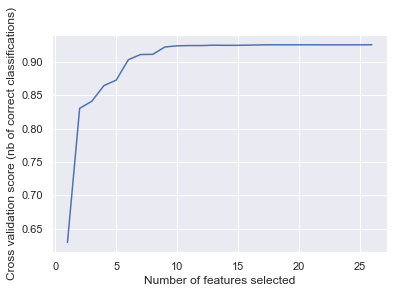

In [44]:
X = X_safe.copy(deep=True)
X=X.select_dtypes(include=np.number)
y=y_safe

pipe = Pipeline(steps=[('impute',SimpleImputer(strategy='mean')),('scale',StandardScaler())])
X_scaled = pipe.fit_transform(X)
# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_scaled, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
